In [2]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

# **Data Reading and Understanding**

In [3]:
# Parameters
data_dir = "/kaggle/input/teethdata/Teeth_Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
BASE_DIR = 'teethdata/Teeth_Dataset'

In [6]:
#Load Trainig Data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Training",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=123,
)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Validation",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
)

# Load test dataset 
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Testing",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [7]:
class_names = train_ds.class_names
print("Class names:", class_names)
num_classes=7

Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


Distripution of the data 

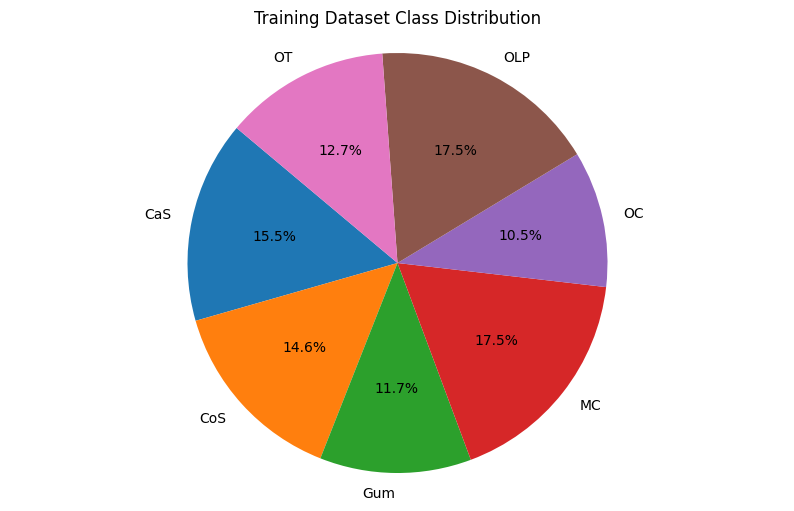

In [8]:
# Count samples per class
class_counts = {class_name: 0 for class_name in class_names}
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Training Dataset Class Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()


Sample of the data

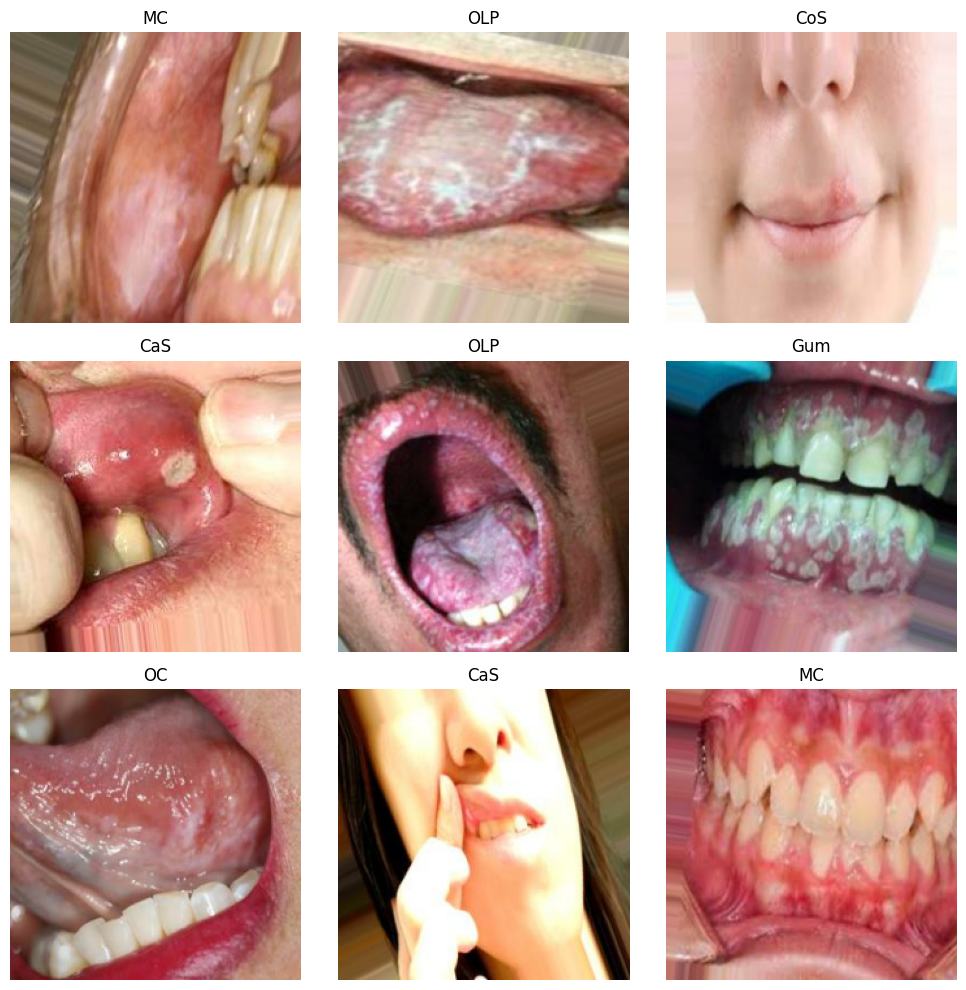

In [9]:
#sample images from the training set
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # Take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()


# **Preprocessing**

Denoising + sharpening

In [10]:
input_dir = "/kaggle/input/teethdata/Teeth_Dataset/Training"
output_dir = "Processed/Training"

# Make sure dir is clean
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

In [11]:
# Processing parameters
target_size = (128, 128)
blur_kernel = (3, 3)
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

# Loop through each class folder
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create same class folder in output
    output_class_path = os.path.join(output_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    # Process each image in the class folder
    for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        input_img_path = os.path.join(class_path, img_name)
        output_img_path = os.path.join(output_class_path, img_name)

        # Read
        img = cv2.imread(input_img_path)
        if img is None:
            continue

        # Resize
        img_resized = cv2.resize(img, target_size)

        # Blur
        blurred = cv2.GaussianBlur(img_resized, blur_kernel, 0)

        # Sharpen
        sharpened = cv2.filter2D(blurred, -1, sharpen_kernel)

        # Save
        cv2.imwrite(output_img_path, sharpened)

Processing OLP: 100%|██████████| 540/540 [00:01<00:00, 465.06it/s]


In [12]:
# Paths
input_ir = "/kaggle/input/teethdata/Teeth_Dataset/Validation"
output_dir = "Processed/Validation"

os.makedirs(output_dir, exist_ok=True)

# Preprocessing parameters
target_size = (128, 128)
blur_kernel = (3, 3)
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

# Loop through each class folder in Validation
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    output_class_path = os.path.join(output_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    for img_name in tqdm(os.listdir(class_path), desc=f"Processing Validation {class_name}"):
        input_img_path = os.path.join(class_path, img_name)
        output_img_path = os.path.join(output_class_path, img_name)

        img = cv2.imread(input_img_path)
        if img is None:
            continue

        img_resized = cv2.resize(img, target_size)
        blurred = cv2.GaussianBlur(img_resized, blur_kernel, 0)
        sharpened = cv2.filter2D(blurred, -1, sharpen_kernel)

        cv2.imwrite(output_img_path, sharpened)

Processing Validation OLP: 100%|██████████| 540/540 [00:01<00:00, 447.43it/s]


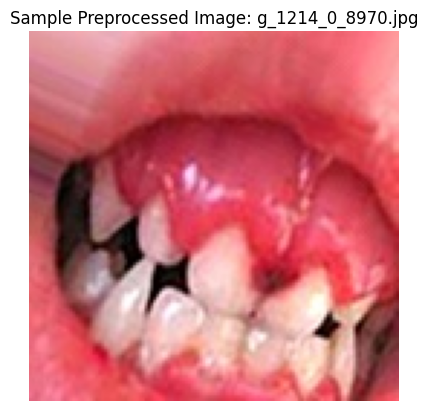

In [13]:
#sample
class_dir = "/kaggle/working/Processed/Training/Gum"

# Pick one random image from that folder
img_name = random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, img_name)

# Load and convert BGR to RGB
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.imshow(img_rgb)
plt.title(f"Sample Preprocessed Image: {img_name}")
plt.axis('off')
plt.show()

**Final Data**

In [14]:
#Final Trainig Data
output_dir = "/kaggle/working/Processed"
final_train = tf.keras.preprocessing.image_dataset_from_directory(
    output_dir + "/Training",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=123,
)

#Final Validate Data
final_val = tf.keras.preprocessing.image_dataset_from_directory(
    output_dir + "/Validation",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
)

Found 3087 files belonging to 7 classes.
Found 3087 files belonging to 7 classes.


In [15]:
# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply to all datasets
final_train = final_train.map(lambda x, y: (normalization_layer(x), y))
final_val = final_val.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


# **Data Augmentation**

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),          # rotate up to 20%
    tf.keras.layers.RandomZoom(0.1),              # zoom in/out 10%
    tf.keras.layers.RandomContrast(0.1),          # adjust contrast
])

In [21]:
#Combine Resize + Normalize + Augmentation
train_preprocessing = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    data_augmentation
])


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

final_train = final_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
final_val = final_val.cache().prefetch(buffer_size=AUTOTUNE)


# **CNN Model**

**Model Architicture**

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [24]:
model = models.Sequential([
    layers.InputLayer(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    laayers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])


In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,237,447 (50.50 MB)

 Trainable params: 13,236,487 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

**Training**

In [26]:
epochs = 35
history = model.fit(final_train,
                    validation_data=final_val,
                    epochs=epochs)


Epoch 1/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.2570 - loss: 10.3063 - val_accuracy: 0.1493 - val_loss: 12.6136
Epoch 2/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.3095 - loss: 1.8049 - val_accuracy: 0.1458 - val_loss: 31.0135
Epoch 3/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.3177 - loss: 1.7761 - val_accuracy: 0.2676 - val_loss: 7.8129
Epoch 4/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - accuracy: 0.3447 - loss: 1.6725 - val_accuracy: 0.2643 - val_loss: 5.2924
Epoch 5/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 443s 4s/step - accuracy: 0.4047 - loss: 1.5540 - val_accuracy: 0.2672 - val_loss: 2.7327
Epoch 6/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.3847 - loss: 1.5743 - val_accuracy: 0.3350 - val_loss: 2.8758
Epoch 7/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.3980 - loss: 1.5278 - val_accuracy: 0.4464 - val_loss: 1.3848
Epoch 8/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 390s 4s/step - accuracy: 0.4489 - loss: 1.3959 - val_accuracy: 0.3175 

**Evaluation**

In [27]:
val_loss, val_accuracy = model.evaluate(final_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 71s 731ms/step - accuracy: 0.7180 - loss: 1.3986
Validation Loss: 0.8350
Validation Accuracy: 0.7969


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

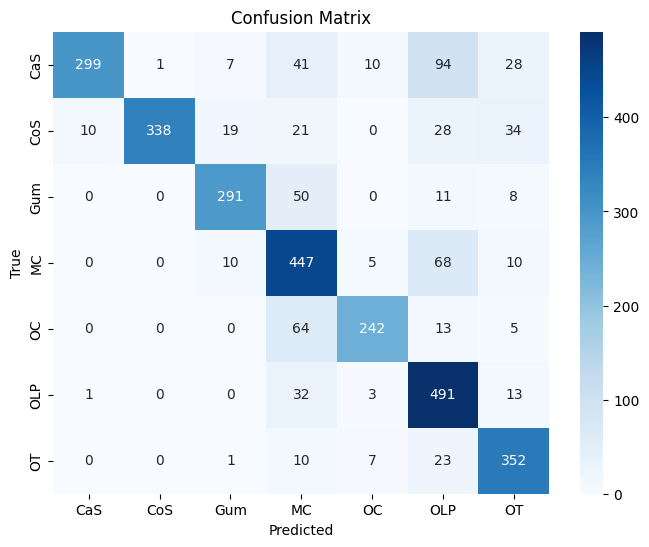

In [30]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get all predictions and true labels
y_true = []
y_pred = []

for images, labels in final_val:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Save The Model**

In [37]:
model.save('teeth_cnn_model.h5')